# Creation of the CNN

### Importations 

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import pandas as pd
import time
import h5py


from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics




print(torch.__version__)

1.0.1.post2


### The Aim 

Some explation about the purpose of this project.

### The Data

Some insight about the data.

In [4]:
Dataset = pd.read_pickle("/home/janjar/Dataset/Trainingset/Training_dataframe.pkl")
Dataset[1029:]

,Room,Array_position,Distance,Absorption,SNR,Audio_file,Phase_Matrix,Label,Angle
1029,1,"[4.39850161295675, 1.5702471407416707, 1.5]",2.0,0.537,[15],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,30,150.0
1030,1,"[2.0256773003933173, 1.2533760344507048, 1.5]",2.0,0.537,[5],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,31,155.0
1031,1,"[1.0487413744095253, 3.4388505167580092, 1.5]",2.0,0.537,[15],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,32,160.0
1032,1,"[2.8673261273287527, 4.995594558899781, 1.5]",2.0,0.537,[10],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,33,165.0
1033,1,"[4.875989504238883, 3.6932989109940606, 1.5]",2.0,0.537,[20],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,34,170.0
1034,1,"[4.1969684380281995, 1.3977308096439185, 1.5]",2.0,0.537,[5],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,35,175.0
1035,1,"[1.8030798618842838, 1.3976947285323391, 1.5]",2.0,0.537,[20],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,36,180.0


### Usefull variables

#### Defining our number of samples.

In [5]:
nb_freq = 256
nb_time = 360
nb_mics = 4
number_of_rooms = Dataset.shape[0]
print(number_of_rooms)

1036


## Treating the Training Data.

### Loading the phase matrices in tensors with respect to the indexing shown in the dataframe.

In [6]:
#path containing the Training data on the machine you are working on.
#path = "/home/janjar/Dataset/Trainingset/"

data_matrix = np.zeros([number_of_rooms,nb_mics,nb_freq,nb_time])
for i in range(number_of_rooms):
    fileName_matrix = Dataset.iloc[i]['Phase_Matrix']
    #print(fileName_matrix)
    fileObject2 = open(fileName_matrix, 'rb')
    matrix_loaded = pkl.load(fileObject2)
    fileObject2.close()
    data_matrix[i] = matrix_loaded
data_matrix.shape    

(1036, 4, 256, 360)

In [7]:
data_matrix = torch.from_numpy(data_matrix)
data_matrix = data_matrix.view(-1,nb_mics,nb_freq,nb_time)
data_matrix = data_matrix.type('torch.FloatTensor')
data_matrix.shape

torch.Size([1036, 4, 256, 360])

In [8]:
final_data = torch.ones([number_of_rooms*nb_time,nb_mics,nb_freq], dtype=torch.float64)

In [10]:
i = 0
for setup in range(number_of_rooms):
     for nb_tf in range(nb_time):
        final_data[i] = data_matrix[setup,:,:,nb_tf]
        i = i+1   

In [11]:
final_data.shape

torch.Size([372960, 4, 256])

## Treating the Training Labels.

### Function that reshape a label into the right format for the data_targets.

In [12]:
def prep_targets(index,label):
    target = torch.tensor(label)
    target = target.expand(nb_time,1)
    return target

In [13]:
data_targets = torch.zeros([number_of_rooms], dtype=torch.float64)
for i in range(number_of_rooms):
    data_targets[i] = Dataset.iloc[i]['Label']
data_targets.shape   

torch.Size([1036])

In [14]:
len(data_targets)

1036

In [15]:
final_targets = torch.ones([number_of_rooms*nb_time], dtype=torch.float64)
test = []
for i in range(number_of_rooms):
    curr = [data_targets[i].item()]*nb_time
    test.append(curr)
    

In [16]:
final_targets = torch.FloatTensor(test)
final_targets = final_targets.flatten()
final_targets.shape

torch.Size([372960])

In [17]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [18]:
final_data,final_targets = unison_shuffled_copies(final_data,final_targets)

## Treating the Test Data.

In [27]:
Test_data = h5py.File('DOA_test.hdf5')
X_test = Test_data['features']                   # These are the phase maps for each time frame
Y_test = Test_data['targets']
X_test = np.array(X_test)                        # size = (Number of time frames,1,256,4)
Y_test = np.array(Y_test)
X_test,Y_test = unison_shuffled_copies(X_test,Y_test)
Xtest = torch.from_numpy(X_test)
Ytest = torch.from_numpy(Y_test)

X_test.shape, Y_test.shape,Xtest.shape,Ytest.shape

((7281, 1, 256, 4),
 (7281, 37),
 torch.Size([7281, 1, 256, 4]),
 torch.Size([7281, 37]))

# Architecture 1.0 : vanilla CNN for DOA 

 In this section, we will focus on building a vanilla CNN in order to recognize the directions of arrival of the   sound in a specific room. Once done, we will then compare "by hand" the labelel dataset to the predicted values. This is the most basic setup and will try to improve latter.

## 1.1 Creating Models

In [28]:
class Net(nn.Module):
    def __init__(self,nb_hidden = 50, n = 4):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=2)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=2)
        self.conv3 = nn.Conv2d(8 ,8, kernel_size=2)
        self.fc1 = nn.Linear(390096, nb_hidden)# (1x8064) being the dim of the censor obtained by flattening the output of the 3rd CL.
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(nb_hidden*4,nb_hidden)
        self.fc3 = nn.Linear(nb_hidden,2)
        
    
    def forward(self, x, n):
        #print("What actually enters the model:",x.shape)
        test =  x[:,:,0,:,:].view(-1,1,129,390)
        #print("Shape of test:",test.shape)
        output = torch.zeros([390096,1])
        for i in range(n):
            
            y = x[:,:,i,:,:].view(-1,1,129,390)
            y = F.relu(self.conv1(y)) 
            y = F.relu(self.conv2(y))
            y = F.relu(self.conv3(y))
            y = F.relu(self.fc1(y.view(-1, 390096)))
            
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y),1)
                
        output = F.relu(self.fc2(output))
        output = self.dropout(output)
        output = F.softmax(self.fc3(output))        

        return output            

In [29]:
class ws_Net(nn.Module):
    def __init__(self,nb_hidden = 50, n = 390 ):
        super(ws_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=2)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=2)
        self.conv3 = nn.Conv2d(8 ,8, kernel_size=2)
        self.fc1 = nn.Linear(1008, nb_hidden)# (1x1008) being the dim of the censor obtained by flattening the output of the 3rd CL.
        self.fc2 = nn.Linear(nb_hidden*n,512)
        self.fc3 = nn.Linear(512,2)
        
    
    def forward(self, x, n):
        
        #print("What actually enters the model:",x.shape)
        test =  x[:,:,:,:,0].view(-1,1,4,129)
        #print("Shape of test:",test.shape)
        output = torch.zeros([1008,1])
        
        for i in range(n):
            y = x[:,:,:,:,i].view(-1,1,4,129)
            y = F.relu(self.conv1(y)) 
            y = F.relu(self.conv2(y))
            y = F.relu(self.conv3(y))
            y = F.relu(self.fc1(y.view(-1, 1008)))
            
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y),1)
                
        #print("Shape of the out of fc1:",output.shape)        
                
        output = F.relu(self.fc2(output))
        
        #print("Shape of the out of fc2:",output.shape) 

        output = F.softmax(self.fc3(output))   
        
        return output  

In [228]:
class SimpleModel(nn.Module):
    
    def __init__(self, nb_hidden=512,phase_map=64):
        super(SimpleModel, self).__init__()
        self.cl1 = nn.Conv2d(1, phase_map, kernel_size=2)
        self.cl2 = nn.Conv2d(phase_map, phase_map, kernel_size=2)
        self.cl3 = nn.Conv2d(phase_map, phase_map, kernel_size=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear((nb_freq-3)*phase_map,nb_hidden)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(nb_hidden,nb_hidden)
        self.fc3 = nn.Linear(nb_hidden,37)
 
 
    def forward(self, x):
       
        x = F.relu(self.cl1(x))
        x = F.relu(self.cl2(x))
        x = F.relu(self.cl3(x))
        x = self.dropout(x)
        x = F.relu(self.fc1(x.view(-1, (nb_freq-3)*64)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def compute_nb_errors(self,model, data_input, data_target, mini_batch_size):

        nb_data_errors = 0
        for b in range(0, data_input.size(0), mini_batch_size):
            a = model(data_input.narrow(0, b, mini_batch_size))
            val = torch.max(a,1)[1]
            for k in range(mini_batch_size):
                if data_target.data[b + k] != val[k]:
                    nb_data_errors = nb_data_errors + 1

        return nb_data_errors

### Preparing the Data

In [229]:
def prep_input_vanilla(train_input):
    new_train_input = train_input.view(-1,1,nb_mics,nb_freq)
    return new_train_input

In [230]:
def prep_test_input(train_input):
    new_train_input = train_input.view(-1,1,nb_freq,nb_mics)
    return new_train_input

In [231]:
def prep_input_model2(train_input):
    new_train_input = train_input.view(-1,1,nb_mics,nb_freq,nb_time)
    return new_train_input

In [232]:
train_data = prep_input_vanilla(final_data)
train_data = train_data.float()
train_data.shape

torch.Size([372960, 1, 4, 256])

In [233]:
train_data2 = prep_input_model2(data_matrix)
train_data2.shape

torch.Size([1036, 1, 4, 256, 360])

In [234]:
test_data = prep_input_vanilla(Xtest[0:7280])
test_data = test_data.float()
test_data[0]

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.1349, -2.2863,  1.5819],
         [-1.5529,  3.1098,  0.5469,  ..., -1.3438,  2.7477,  0.3691],
         [-0.2782,  2.7755, -0.5819,  ...,  0.3343, -0.2837,  1.0001],
         [ 3.1078, -2.6808, -2.7763,  ..., -1.1026,  0.6450, -0.1436]]])

### Turning test labels from Hot-One to Index

In [235]:
_,test_targets = Ytest[0:7280].max(dim=1)
test_targets[3004]

tensor(24)

train_data = prep_input_model2(data_matrix)
train_data.shape

In [236]:
def prep_labels_vanilla(train_input):
    new_train_input = train_input.view(-1)
    return new_train_input

In [40]:
train_targets = prep_labels_vanilla(final_targets)
train_targets = train_targets.to(dtype=torch.int64)
train_targets2 =  prep_labels_vanilla(data_targets)
train_data, train_targets, train_data2, train_targets2 = Variable(train_data), Variable(train_targets), Variable(train_data2),Variable(train_targets2)
train_data.shape,train_data2.shape,train_targets.shape,train_targets2.shape

(torch.Size([372960, 1, 4, 256]),
 torch.Size([1036, 1, 4, 256, 360]),
 torch.Size([372960]),
 torch.Size([1036]))

### Spliting the Training Data into Training/Validation.

In [253]:
training_data = train_data[0:1000]
training_targets = train_targets[0:1000]
validation_data = train_data[365000:]
validation_targets = train_targets[365000:]
training_data.shape, validation_data.shape, training_targets.shape, validation_targets.shape,len(training_targets),len(validation_targets)

(torch.Size([1000, 1, 4, 256]),
 torch.Size([7960, 1, 4, 256]),
 torch.Size([1000]),
 torch.Size([7960]),
 1000,
 7960)

### End of Sanity check.

## 1.2 Training the model

In [266]:
model = Net()

In [267]:
model1 = ws_Net()

In [268]:
model2 = (SimpleModel()).float()

In [269]:
pytorch_total_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
pytorch_total_params

8605669

In [270]:
mini_batch_size = 30
nb_epochs = 100
eta = 0.001 #learning rate
criterion = torch.nn.CrossEntropyLoss() #Cross Entropy
optimizer = torch.optim.Adam(model2.parameters(), lr = eta, weight_decay=0.001) #ADAM
optim_no_wd = torch.optim.Adam(model2.parameters(), lr = eta)
net_ch = 4
ws_ch = 390

### Need to figure out how to use mini-batches to gain time in this configuration.
#### train_model is the method used to update the weights.

In [263]:
def train_model_3(model, optimizer1, nb_epochs, train_input, train_target ,mini_batch_size,n):

    start = time.time()
    for e in range(0,nb_epochs):
        start_ep = time.time()
        for b in range(0, train_input.size(0), mini_batch_size):
            start = time.time()
            #print("Shape of the input of the model:",train_input.narrow(0, b, mini_batch_size).shape)
            output = model(train_input.narrow(0, b, mini_batch_size),n)
            target = train_target.narrow(0, b, mini_batch_size)
            _,indices = output.max(1)
            #print("batch :",b," Output :",output,"Targets:", target)
            loss = criterion(output,target.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
        if (e == 0):
            end_ep = time.time()
            print("Time for 1 epochs is :{:5}".format(-(start_ep-end_ep)))
            
        print("Loss for epoch{:3} is {:5} ".format(e,loss.data.item()))
            
    end = time.time()
    print("Time the hole training is :{:5}".format(-(start-end)))

       

    

In [272]:
def train_simple_model(model, optimizer, nb_epochs, train_input, train_target ,mini_batch_size):

    start = time.time()
    losses = []
    for e in range(0,nb_epochs):
        start_ep = time.time()
        train_input,train_target = unison_shuffled_copies(train_input,train_target)
        for b in range(0, train_input.size(0), mini_batch_size):
            start = time.time()
            #print("Shape of the input of the model:",train_input.narrow(0, b, mini_batch_size).shape)
            output = model((train_input.narrow(0, b, mini_batch_size)).float())
            target = train_target.narrow(0, b, mini_batch_size)
            _,indices = output.max(1)
            #print("batch :",b," Output :",indices,"Targets:", target)
            #print(output.shape,target.shape)
            loss = criterion(output,target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (e == 0):
            end_ep = time.time()
            print("Time for 1 epochs is :{:5}".format(-(start_ep-end_ep)))
            
        print("Loss for epoch{:3} is {:5} ".format(e,loss.data.item()))
        losses.append(loss.data.item())   
    end = time.time()
    print("Time the hole training is :{:5}".format(-(start-end)))
    return losses

       

In [273]:
losses = train_simple_model(model2,optimizer,nb_epochs,test_data[0:3000],test_targets[0:3000],mini_batch_size)

Time for 1 epochs is :8.697235345840454
Loss for epoch  0 is 2.2114689350128174 
Loss for epoch  1 is 1.8287593126296997 
Loss for epoch  2 is 0.5783843994140625 
Loss for epoch  3 is 0.24865855276584625 
Loss for epoch  4 is 0.05395997315645218 
Loss for epoch  5 is 0.06532834470272064 
Loss for epoch  6 is 0.26228854060173035 
Loss for epoch  7 is 0.12573477625846863 
Loss for epoch  8 is 0.026700815185904503 
Loss for epoch  9 is 0.015720795840024948 
Loss for epoch 10 is 0.07035230100154877 
Loss for epoch 11 is 0.11976532638072968 
Loss for epoch 12 is 0.07391288876533508 
Loss for epoch 13 is 0.06362795829772949 
Loss for epoch 14 is 0.16824688017368317 
Loss for epoch 15 is 0.02579859085381031 
Loss for epoch 16 is 0.2639557719230652 
Loss for epoch 17 is 0.032956503331661224 
Loss for epoch 18 is 0.23973461985588074 
Loss for epoch 19 is 0.01770791970193386 
Loss for epoch 20 is 0.046083562076091766 
Loss for epoch 21 is 0.017593447118997574 
Loss for epoch 22 is 0.101190410554

In [286]:
test = model2(test_data[2010:2020])
_,pred = test.max(1)
pred

tensor([12, 21,  6, 15,  6, 24, 18,  9, 21,  9])

## Doing the prediction with the trained model provided by the paper.

In [122]:
from __future__ import print_function
import numpy as np
import h5py
import tensorflow as tf
from keras.models import model_from_json, load_model
from keras.optimizers import SGD, Adam, RMSprop,Adagrad
import scipy.io
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [53]:
# Load trained model from the json file

json_file = open('Model_sin_CNN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
print(type(loaded_model))
# Load weights 

loaded_model.load_weights('Weights_sin_CNN.h5')
print("Loaded model from disk")

# Define the optimizer and compile the model

lrate = 0.001
adam = Adam(lr =lrate,beta_1=0.9,beta_2=0.999,epsilon=1e-08)
loaded_model.compile(loss='categorical_crossentropy', optimizer= adam)

<class 'keras.engine.training.Model'>


/home/janjar/test/lib/python3.5/site-packages/keras/utils/conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


Loaded model from disk


In [54]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 256, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 255, 3)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 254, 2)        16448     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 253, 1)        16448     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16192)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16192)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8290816   
__________

In [55]:
print("Types of data:",type(X_test),type(Y_test))

Types of data: <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [56]:
X_test.shape,Y_test.shape

((7281, 1, 256, 4), (7281, 37))

## Doing the predictions on the test set.

In [154]:
def predict(data):
    pred = loaded_model.predict(data)   
    pred = np.argmax(pred, axis=1)
    return pred

In [155]:
def get_labels(labels):
    labels = np.argmax(labels, axis=1)
    return labels

In [156]:
pred = predict(X_test)

In [169]:
count = np.bincount(pred)
count.shape

(37,)

In [158]:
pred[0:40]

array([ 9, 17, 27, 30, 28, 18,  2,  9, 18, 30, 30,  8, 12,  2, 18, 17, 21,
        8, 31,  6,  6, 16, 31, 27, 24, 13,  2, 21,  9, 18, 17,  9,  9, 19,
       30, 25,  2, 30, 19, 29])

In [159]:
labels = get_labels(Y_test)
labels[0:50]

array([ 9, 18, 27, 30, 30, 18, 24,  9, 18, 30, 30,  6, 12, 30, 18, 18, 21,
        9, 30,  6,  6, 15, 30, 27, 24, 12, 30, 21,  9, 18, 18,  9,  9, 18,
       30, 30, 24, 30, 18, 24, 24,  9, 30, 24, 15, 21,  6, 21,  9, 18])

In [170]:
count = np.bincount(labels)
count.shape

(31,)

In [171]:
present_labels = np.array([5,8,11,14,17,20,23,26,29])

## Doing the predictions of the Validation test 

### Treating the validation data generated to test the pretrained model on it.

In [172]:
self_test_data = prep_test_input(validation_data)
self_test_data = self_test_data.numpy()
self_test_targets = validation_targets.numpy()
self_test_data.shape,self_test_targets.shape

((7960, 1, 256, 4), (7960,))

In [173]:
self_pred = predict(self_test_data)

In [174]:
self_pred[10:20]

array([ 2,  4, 14, 13,  2,  5, 10,  5, 34, 34])

In [175]:
self_test_targets[0:10]

array([ 6, 22, 18,  1, 10,  9, 36, 30,  1,  9])

In [178]:
#Calculation some metrics on the testing set.
report = classification_report(labels, pred, digits=4)
accuracy = accuracy_score(labels, pred)
print(report)
print("The accuracy score the model on the test set is:",accuracy)

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         0
           2     0.0000    0.0000    0.0000         0
           3     0.0000    0.0000    0.0000         0
           4     0.0000    0.0000    0.0000         0
           5     0.0000    0.0000    0.0000         0
           6     0.9398    0.6180    0.7457       809
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     0.9325    0.6316    0.7531       809
          10     0.0000    0.0000    0.0000         0
          11     0.0000    0.0000    0.0000         0
          12     0.9678    0.6687    0.7909       809
          13     0.0000    0.0000    0.0000         0
          14     0.0000    0.0000    0.0000         0
          15     0.9954    0.5315    0.6930       809
          16     0.0000    0.0000    0.0000         0
          17     0.0000    0.0000    0.0000         0
          18     0.7494    

### Showing the confusion matrix of the classification.

In [176]:
cm = metrics.confusion_matrix(labels, pred)

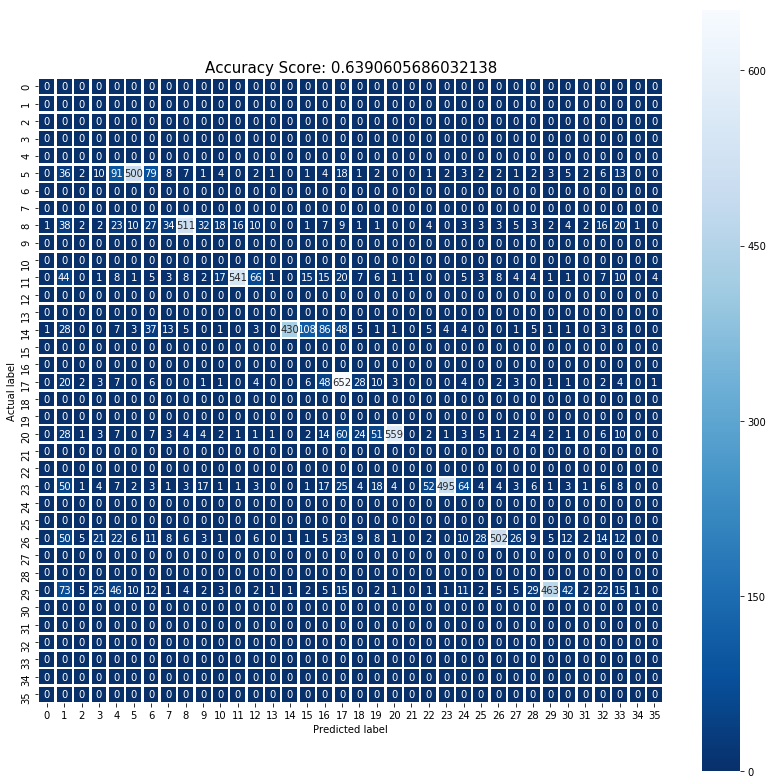

In [181]:
plt.figure(figsize=(14,14))
sns.heatmap(cm, annot=True, fmt="d", linewidths=1.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

### Defining a new test loss less punitive for this classification problem.

In [210]:
print(test_data.shape,test_targets.shape)
out_pred = loaded_model.predict(X_test[0:7280])

torch.Size([7280, 1, 4, 256]) torch.Size([7280])


In [211]:
print(out_pred.shape)
out_pred = torch.from_numpy(out_pred)
cross_loss = criterion(out_pred,test_targets)

(7280, 37)


In [212]:
print(cross_loss)

tensor(3.0405)


In [213]:
mse = torch.nn.MSELoss()

In [214]:
#Turning the output into classes and calculating the MSEloss.
#_,out_pred = out_pred.max(1)
print(out_pred.shape,test_targets.shape)

torch.Size([7280, 37]) torch.Size([7280])
